## Feature Importance
Feature Importance: After establishing that certain GIDs have different abundances across categories, we can further delve into which specific GIDs are the most influential in determining the category. This can be done using techniques like:

__Logistic Regression with L1 Regularization:__ This can help in feature selection by shrinking the coefficients of less important features to zero.
Random Forest or Gradient Boosting: These tree-based models can provide a feature importance score for each GID.
__Influence:__ Since the 'Influence' feature accounts for both abundance and frequency, it might be worthwhile to also consider this feature in the analysis. We can repeat the above steps using 'Influence' as the dependent variable instead of 'Abundance' to see if it provides any additional insights. Additionally at the end we have a list of most relevant Genera to continue to book 4.

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import braycurtis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error

In [104]:
pd.options.display.float_format = '{:.4f}'.format
#Reading the data
OLS_all_o = pd.read_excel('data/OLS_all.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}}) 
Influencers_OLS_o = pd.read_excel('data/Influencers_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques_OLS_o = pd.read_excel('data/uniques_cat.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques_23_OLS_o = pd.read_excel('data/uniques_plus_23.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
original_o = pd.read_excel('data/original.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})

In [105]:
def prepare_data(df, category_column, index_column=None):
    df_prepared = df.copy()
    if index_column:
        df_prepared = df_prepared.set_index(index_column)
    category = df_prepared[category_column]
    df_prepared = df_prepared.drop(columns=[category_column], axis=1)
    return df_prepared, category

def standardize_data(df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return pd.DataFrame(X_scaled, columns=df.columns)

def perform_pca(X_scaled, n_components=None):
    if n_components is None:
        pca = PCA()
    else:
        pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    return pca, X_pca, explained_variance_ratio, cumulative_variance_ratio

def plot_scree(pca, title):
    explained_var = pca.explained_variance_ratio_
    plt.figure(figsize=(7, 5))
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(explained_var) + 1), np.cumsum(explained_var), where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_pca_2d(X_pca, category, title):
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Category'] = category.values
    colors = ['green', 'orange', 'red']
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Category", data=pca_df, palette=colors)
    plt.title(title)
    plt.show()

def pca_pipeline(df, category_column, index_column=None, n_components=None, dataset_name=None):
    df_prepared, category = prepare_data(df, category_column, index_column)
    X_scaled = standardize_data(df_prepared)

    # Perform PCA with all components for scree plot
    pca_all = PCA()
    pca_all.fit(X_scaled)
    explained_variance_ratio_all = pca_all.explained_variance_ratio_
    
    # Perform PCA with selected components for visualization
    pca, X_pca, explained_variance_ratio, cumulative_variance_ratio = perform_pca(X_scaled, n_components)
    
    if dataset_name:
        plot_scree(pca_all, f"Scree Plot for {dataset_name}")
        plot_pca_2d(X_pca, category, f"PCA 2D Visualization for {dataset_name}")
    
    results = {
        'pca': pca,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'X_pca': X_pca
    }
    return results

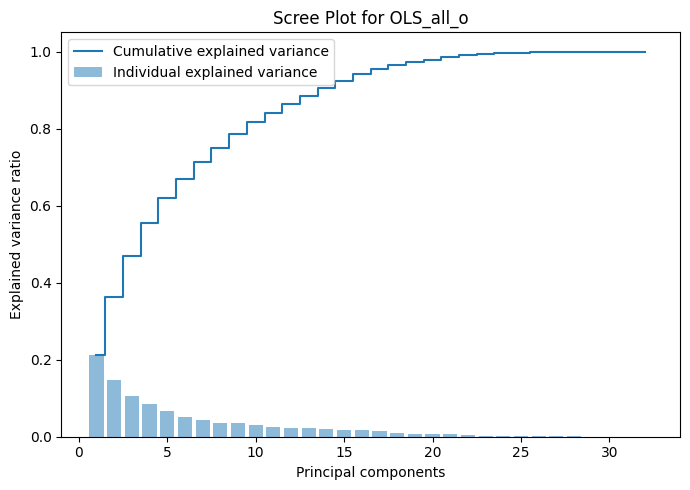

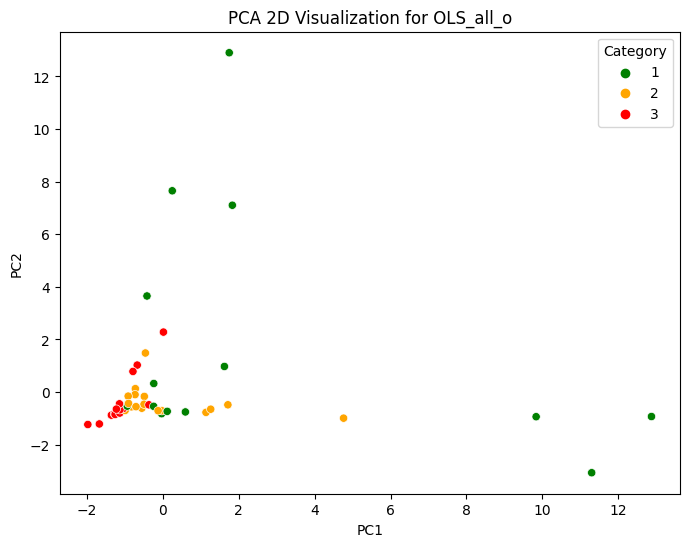

In [106]:
OLS_all_o = OLS_all_o.drop(columns='Unnamed: 0', axis=1)
OLS_all_o['Sites'] = OLS_all_o['Sites'].astype(str)
OLS_all_o['Category'] = OLS_all_o['Category'].astype(int)
OLS_all_o = OLS_all_o.set_index("Sites")

OLS_all_pca = pca_pipeline(OLS_all_o, 'Category', n_components=2, dataset_name='OLS_all_o')

**OLS_all**:
   - The scenario for the whole data is more intricate. The categories are not as distinctly separated, indicating a more complex interplay of features.
   - While category 1 also forms a 'Y' shape, the distinction is less clear due to the overlap with categories 2 and 3. This overlap suggests shared characteristics or interactions among the categories.
   - Category 3, although forming a linear pattern, also has a few dots that spread out, indicating some variability within this category.
   - The mixed pattern observed suggests a more intricate relationship among the categories, possibly due to the inclusion of a broader set of genera in the whole data.
**Interpretation**:
 The distinct linear pattern of category 3 and 1 in both dataframes suggests a consistent underlying structure or set of interactions. However, the whole data presents a more convoluted picture, with overlaps and mixed patterns. This complexity might arise from the inclusion of a broader set of genera, some of which might not be as influential or distinct as the ones in the `influencers_final` dataframe.

### Computing PCA and Varianza -Scree Plots for Influencers_OLS

In [107]:
Influencers_OLS_o.head(2)

,Unnamed: 0,Sites,Category,678,565,23,864,712,214,549,...,526,584,725,408,91,351,375,334,871,471
0,0,site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.1508,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,1,site_10,2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,2.4800,2.4200,0.0000,0.0000,0.0000,0.0000,0.0000


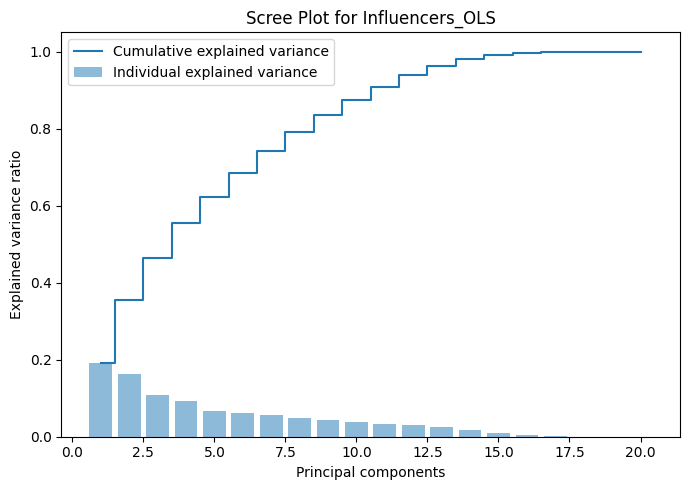

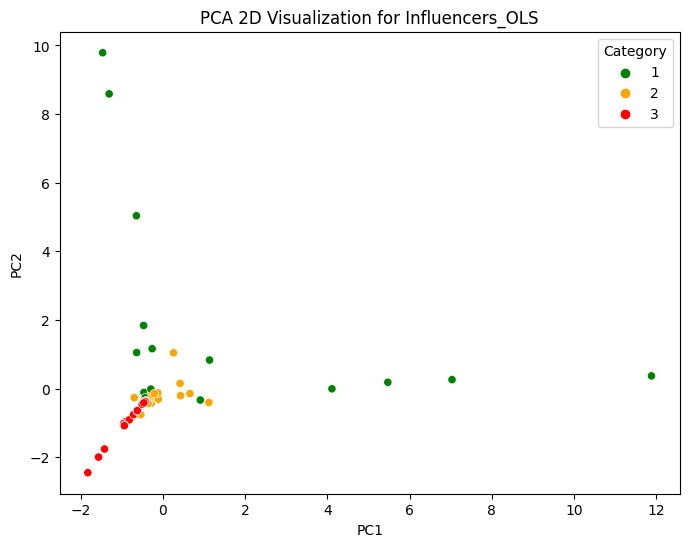

In [108]:
Influencers_OLS_o = Influencers_OLS_o.drop(columns='Unnamed: 0', axis=1)
Influencers_OLS_o['Sites'] = Influencers_OLS_o['Sites'].astype(str)
Influencers_OLS_o['Category'] = Influencers_OLS_o['Category'].astype(int)
Influencers_OLS_o= Influencers_OLS_o.set_index("Sites")

Influencers_OLS_pca = pca_pipeline(Influencers_OLS_o, 'Category', n_components=2, dataset_name='Influencers_OLS')

**Influencers Genera Dataframe (`Influencers_OLS`)**:
   - This dataframe, representing the most influential genera both statistically and quantitatively, shows a clearer separation among the categories, especially between category 3 and the others.
   - Category 3 forms a linear pattern between PC1 and PC2, suggesting a gradient or continuum of variance explained by these components.
   - Category 2 dots align at the end of this linear pattern, indicating they share some characteristics with category 3 but also have distinct features.
   - Category 1 displays a 'Y' shape, with category 3 forming the root, category 2 at the intersection, and the two arms of the 'Y' representing the spread of category 1. This pattern might indicate that category 1 encompasses a broader range of variance or interactions compared to the other categories.  

__Scree Plots:__
The scree plots for the Influencers_OLS and OLS_all datasets visualize the explained variance ratio for each principal component in their respective analyses. The Influencers_OLS dataset appears to decrease its explained variance more steeply compared to the OLS_all dataset.

In both scree plots, a clear "elbow point" is observed around the 5th principal component. This suggests that retaining the first 5 components captures a significant portion of the variance in the data. However, Influencers_OLS seems to achieve a higher explanatory power with fewer features compared to OLS_all. According to the principle of parsimony or Occam's Razor, which states that among competing hypotheses, the one with the fewest assumptions should be selected, in this case Influencers_OLS.


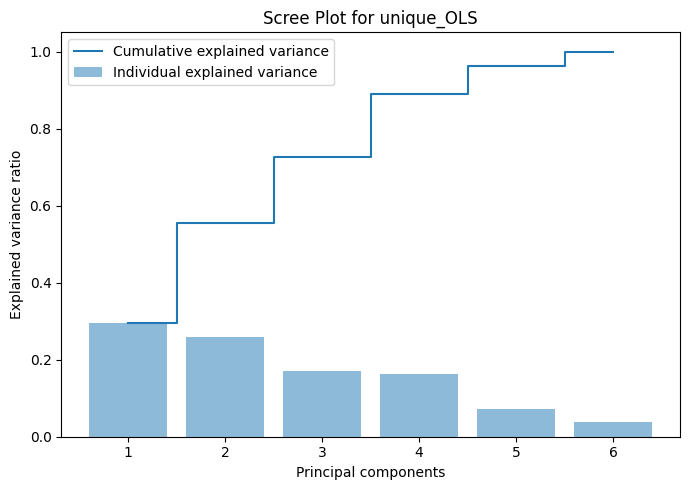

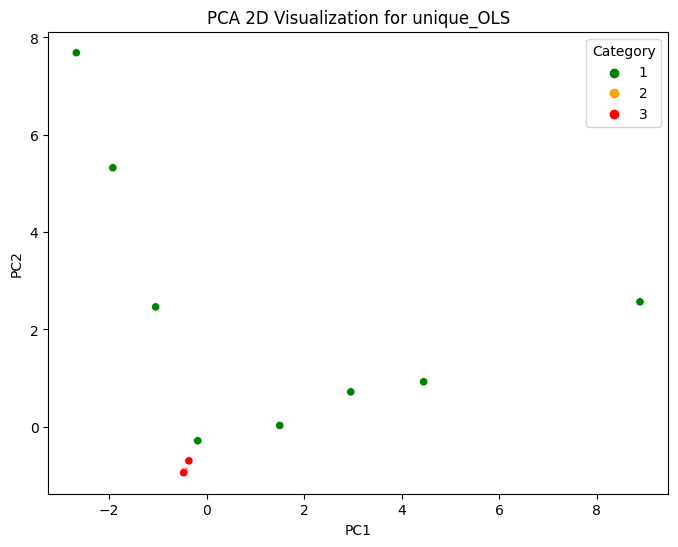

In [109]:
uniques_OLS_o = uniques_OLS_o.drop(columns='Unnamed: 0', axis=1)
uniques_OLS_o['Sites'] = uniques_OLS_o['Sites'].astype(str)
uniques_OLS_o['Category'] = uniques_OLS_o['Category'].astype(int)
uniques_OLS_o= uniques_OLS_o.set_index("Sites")

uniques_pca= pca_pipeline(uniques_OLS_o, 'Category', n_components=2, dataset_name='unique_OLS')

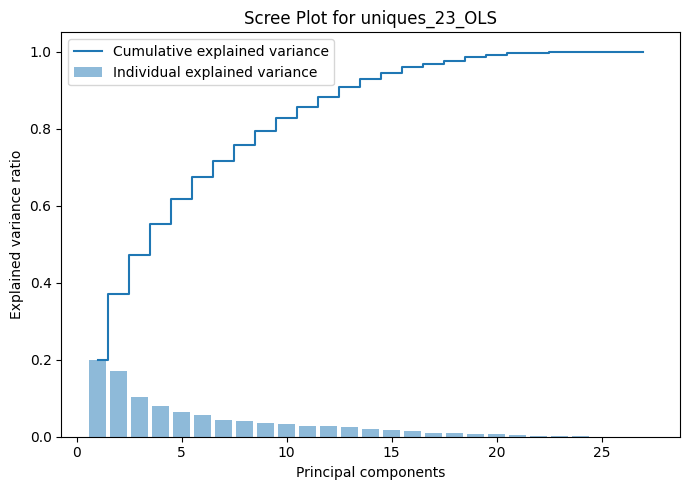

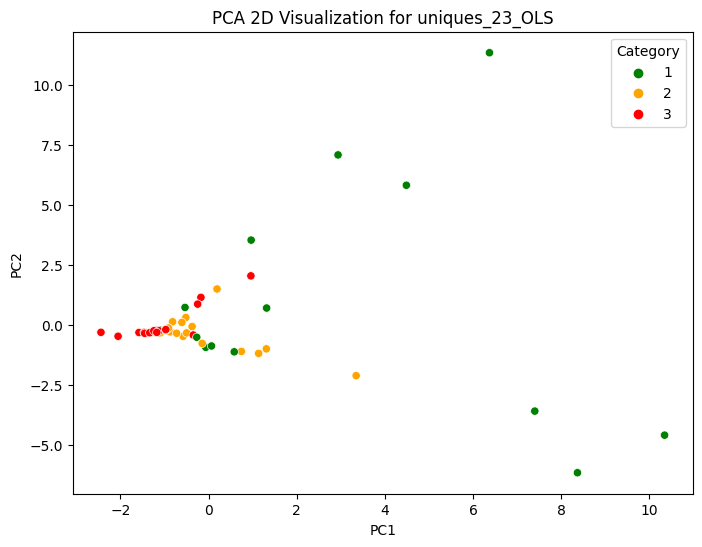

In [110]:
uniques_23_OLS_o = uniques_23_OLS_o.drop(columns='Unnamed: 0', axis=1)
uniques_23_OLS_o['Sites'] = uniques_23_OLS_o['Sites'].astype(str)
uniques_23_OLS_o['Category'] = uniques_23_OLS_o['Category'].astype(int)
uniques_23_OLS_o= uniques_23_OLS_o.set_index("Sites")

uniqus_23_OLS_pca= pca_pipeline(uniques_23_OLS_o, 'Category', n_components=2, dataset_name='uniques_23_OLS')

In [111]:
original_o.head()

,Unnamed: 0,Sites,Category,1,2,3,4,5,6,7,...,873,874,875,876,877,878,879,880,881,882
0,1,site_1,3,0,0.0000,0.0000,0.0000,0.0000,0.4308,0.5170,...,0.0000,0.0000,0.0000,0.0215,0.0000,0.0000,0.0000,0.0000,0.0215,0.0000
1,2,site_2,1,0,0.0000,0.0000,0.0000,0.0000,0.0190,0.3415,...,0.0190,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.0000
2,3,site_3,1,0,0.0000,0.0000,0.0000,0.0000,0.0246,0.3192,...,0.0123,0.0000,0.0000,0.0123,0.0000,0.0000,0.0000,0.0000,0.0246,0.0123
3,4,site_4,1,0,0.0000,0.0154,0.0000,0.0000,0.0176,0.2512,...,0.0022,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0022
4,5,site_5,1,0,0.0000,0.0037,0.0000,0.0000,0.0221,0.5098,...,0.0037,0.0000,0.0037,0.0000,0.0000,0.0000,0.0000,0.0000,0.0110,0.0037


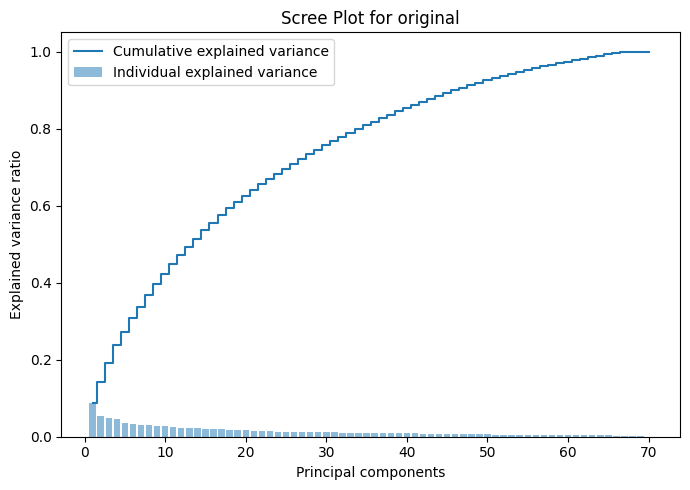

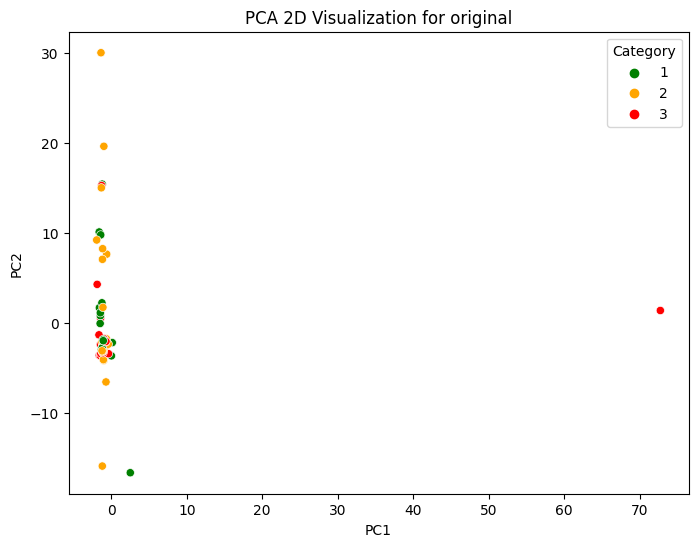

In [112]:
original_o = original_o.drop(columns='Unnamed: 0', axis=1)
original_o['Sites'] = original_o['Sites'].astype(str)
original_o['Category'] = original_o['Category'].astype(int)
original_o= original_o.set_index("Sites")

original_o_pca = pca_pipeline(original_o, 'Category', n_components=2, dataset_name='original')

## Pipeline for Feature Importance using rf and Explained Variance using PCA 
from Notebook Filtering.ipynb after statistical Analyis : without filtering but with Ordinary Least Squares (OLS) regression analysis for whole. And for influencers after filtering on notebook 2 and OLS. For uniques after singling out the unique genera in each category and unique_23_OLS including genera on both fail analysis category but without OLS.
Now we doing for those df:
* __Feature importances__ from RFR give us an idea of which features are most influential in making predictions.
* __The explained variance__ from PCA tells us how much of the data's total variance is captured by each principal component.

In [113]:
def apply_pipeline(df, dataset_name):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()  # 
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target
    X = df.drop(columns=['Category', 'Sites'])
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5)
    rf_mae_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    
        # Fit and predict
        rf_pipeline.fit(X_train, y_train)
        # Predict the labels of the test set
        y_pred = rf_pipeline.predict(X_test)
    
        # Calculate and store MAE
        mae = mean_absolute_error(y_test, y_pred).round(4)
        rf_mae_scores.append(mae)

    print(f"Cross-Validation MAE Scores for RF: {rf_mae_scores}")
    print(f"Average MAE for RF: {np.mean(rf_mae_scores).round(4)}")
      
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred).round(4)
    print(f'Mean Squared Error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(4)
    print(f'Root Mean Squared Error: {rmse}')
    mae = mean_absolute_error(y_test, y_pred).round(4)
    print(f'Mean Absolute Error: {mae}')

    # Extract feature importances from RandomForestRegressor
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    
    # Create a DataFrame to view the results
    df_importances_rf = pd.DataFrame({
            'Features': X.columns,
            'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False) # Sort the features by importance
    
    print(f'Feature Importance by RF: {df_importances_rf}')
          
    return rf_pipeline, df_importances_rf

* **MSE (Mean Squared Error):** Measures the average of the squares of the errors.
* __RMSE (Root Mean Squared Error):__ Square root of MSE. It's in the same units as the output variable and gives a higher penalty for larger errors.
* __MAE (Mean Absolute Error):__ Measures the average of the absolute errors.

In [114]:
# Apply the pipeline the working df
OLS_all_pipe, df_importances_rf = apply_pipeline(OLS_all_o, "OLS_all_o")

OLS_all_o_pipeline:
Cross-Validation MAE Scores for RF: [0.6886, 0.6021, 0.3935, 0.6148, 0.5634]
Average MAE for RF: 0.5725
Mean Squared Error: 0.3921
Root Mean Squared Error: 0.6262
Mean Absolute Error: 0.5634
Feature Importance by RF:    Features  Importance
13      549      0.1883
6        23      0.1233
14      625      0.0887
9       214      0.0845
15      229      0.0751
7       140      0.0611
11      470      0.0488
17      584      0.0425
21       91      0.0410
1       565      0.0295
26      334      0.0287
0       678      0.0240
29      337      0.0220
22      428      0.0193
5       605      0.0176
19      799      0.0143
28       88      0.0134
4       771      0.0124
18      725      0.0108
16       79      0.0089
30      871      0.0085
8       712      0.0081
31      480      0.0064
24      426      0.0060
3       342      0.0043
10       90      0.0039
25      541      0.0026
20      657      0.0024
23      201      0.0018
12       92      0.0016
27      494      0.

In [115]:
Influencers_pipeline, df_importances_rf = apply_pipeline(Influencers_OLS_o, "Influencers_OLS")

Influencers_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.3274, 0.2214, 0.1426, 0.1784, 0.34]
Average MAE for RF: 0.242
Mean Squared Error: 0.2618
Root Mean Squared Error: 0.5116
Mean Absolute Error: 0.34
Feature Importance by RF:    Features  Importance
10      526      0.4318
6       549      0.1748
7       625      0.0948
3       864      0.0908
16      375      0.0595
5       214      0.0459
9       229      0.0309
1       565      0.0289
13      408      0.0092
11      584      0.0070
19      471      0.0056
14       91      0.0055
15      351      0.0050
2        23      0.0042
17      334      0.0033
8       863      0.0019
12      725      0.0010
4       712      0.0000
18      871      0.0000
0       678      0.0000


In [116]:
uniques_pipeline, df_importances_rf = apply_pipeline(uniques_OLS_o, "Uniques_OLS")

Uniques_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.6922, 0.6703, 0.3881, 0.3783, 0.7313]
Average MAE for RF: 0.572
Mean Squared Error: 0.7412
Root Mean Squared Error: 0.8609
Mean Absolute Error: 0.7313
Feature Importance by RF:   Features  Importance
3      541      0.2426
1      342      0.2327
0      410      0.2050
2      201      0.1732
4      799      0.1180
5      494      0.0285


In [117]:
unique_23_OLS_pipeline, df_importances_rf= apply_pipeline(uniques_23_OLS_o, "unique_23_OLS")

unique_23_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.72, 0.6022, 0.3867, 0.6042, 0.5623]
Average MAE for RF: 0.5751
Mean Squared Error: 0.3868
Root Mean Squared Error: 0.622
Mean Absolute Error: 0.5623
Feature Importance by RF:    Features  Importance
10      549      0.1899
6        23      0.1025
11      625      0.0889
8       214      0.0879
12      229      0.0750
5       140      0.0552
9       470      0.0545
16       91      0.0410
13      584      0.0407
1       565      0.0294
21      334      0.0288
23       88      0.0267
17      428      0.0261
0       678      0.0259
4       605      0.0224
24      337      0.0214
15      799      0.0183
14      725      0.0177
7       712      0.0137
25      871      0.0082
2       410      0.0081
3       342      0.0055
19      426      0.0044
26      480      0.0037
20      541      0.0024
18      201      0.0016
22      494      0.0000


Pipeline for clasification fresh

In [118]:
def apply_classification_pipeline(df, dataset_name):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()  # 
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target
    X = df.drop(columns=['Category', 'Sites'])
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5)
    rf_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    
        # Fit and predict
        rf_pipeline.fit(X_train, y_train)
        # Predict the labels of the test set
        y_pred = rf_pipeline.predict(X_test)
    
        # Calculate and store accuracy
        accuracy = accuracy_score(y_test, y_pred).round(4)
        rf_scores.append(accuracy)

    print(f"Cross-Validation Accuracy Scores for RF: {rf_scores}")
    print(f"Average Accuracy for RF: {np.mean(rf_scores).round(4)}")
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Extract feature importances from RandomForestClassifier
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    
    # Create a DataFrame to view the results
    df_importances_rf = pd.DataFrame({
            'Features': X.columns,
            'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False) # Sort the features by importance
    
    print(f'Feature Importance by RF: {df_importances_rf}')
          
    return rf_pipeline, df_importances_rf

In [119]:
# Apply the pipeline the working df
OLS_all_pipe_class, df_importances_rf = apply_classification_pipeline(OLS_all_o, "OLS_all_o")

OLS_all_o_pipeline:
Cross-Validation Accuracy Scores for RF: [0.2857, 0.5, 0.6429, 0.5, 0.4286]
Average Accuracy for RF: 0.4714
Confusion Matrix:
[[1 4 1]
 [0 5 1]
 [0 2 0]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.17      0.29         6
           2       0.45      0.83      0.59         6
           3       0.00      0.00      0.00         2

    accuracy                           0.43        14
   macro avg       0.48      0.33      0.29        14
weighted avg       0.62      0.43      0.37        14

Feature Importance by RF:    Features  Importance
15      229      0.1138
9       214      0.1074
6        23      0.0912
13      549      0.0715
21       91      0.0614
1       565      0.0534
17      584      0.0527
14      625      0.0460
0       678      0.0447
7       140      0.0434
5       605      0.0400
18      725      0.0355
11      470      0.0270
28       88      0.0246
29      337      0.0238
22      428

In [120]:
# Apply the pipeline the working df
Influencers_pipe_class, df_importances_rf = apply_classification_pipeline(Influencers_OLS_o, "Influencers_OLS")

Influencers_OLS_pipeline:
Cross-Validation Accuracy Scores for RF: [0.7857, 0.7857, 0.9286, 0.9286, 0.7143]
Average Accuracy for RF: 0.8286
Confusion Matrix:
[[2 1 0]
 [0 7 0]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.64      1.00      0.78         7
           3       1.00      0.25      0.40         4

    accuracy                           0.71        14
   macro avg       0.88      0.64      0.66        14
weighted avg       0.82      0.71      0.67        14

Feature Importance by RF:    Features  Importance
10      526      0.2326
6       549      0.1008
3       864      0.0839
16      375      0.0785
5       214      0.0720
7       625      0.0653
9       229      0.0643
19      471      0.0459
15      351      0.0416
1       565      0.0406
8       863      0.0399
11      584      0.0371
14       91      0.0231
13      408      0.0211
12      725      0.0159

In [121]:
# Apply the pipeline the working df
uniques_pipe_class, df_importances_rf = apply_classification_pipeline(uniques_OLS_o, "unique_OLS")

unique_OLS_pipeline:
Cross-Validation Accuracy Scores for RF: [0.3571, 0.5, 0.7143, 0.6429, 0.4286]
Average Accuracy for RF: 0.5286
Confusion Matrix:
[[0 6 0]
 [0 6 0]
 [0 2 0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.43      1.00      0.60         6
           3       0.00      0.00      0.00         2

    accuracy                           0.43        14
   macro avg       0.14      0.33      0.20        14
weighted avg       0.18      0.43      0.26        14

Feature Importance by RF:   Features  Importance
2      201      0.2338
3      541      0.2117
1      342      0.2011
0      410      0.1924
4      799      0.1181
5      494      0.0429


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
# Apply the pipeline the working df
uniques23_pipe_class, df_importances_rf = apply_classification_pipeline(uniques_23_OLS_o, "unique_23_OLS")

unique_23_OLS_pipeline:
Cross-Validation Accuracy Scores for RF: [0.3571, 0.4286, 0.7143, 0.5, 0.4286]
Average Accuracy for RF: 0.4857
Confusion Matrix:
[[0 6 0]
 [0 6 0]
 [0 2 0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.43      1.00      0.60         6
           3       0.00      0.00      0.00         2

    accuracy                           0.43        14
   macro avg       0.14      0.33      0.20        14
weighted avg       0.18      0.43      0.26        14

Feature Importance by RF:    Features  Importance
12      229      0.1091
6        23      0.1082
8       214      0.1066
10      549      0.0697
16       91      0.0664
5       140      0.0582
0       678      0.0490
1       565      0.0483
13      584      0.0441
11      625      0.0408
4       605      0.0340
14      725      0.0340
17      428      0.0304
24      337      0.0301
23       88      0.0282
9   

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
# Apply the pipeline the working df
original_pipe_class, df_importances_rf = apply_classification_pipeline(original_o, "original_o")

original_o_pipeline:
Cross-Validation Accuracy Scores for RF: [0.5714, 0.5714, 0.4286, 0.6429, 0.4286]
Average Accuracy for RF: 0.5286
Confusion Matrix:
[[0 5 1]
 [0 6 0]
 [0 2 0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.46      1.00      0.63         6
           3       0.00      0.00      0.00         2

    accuracy                           0.43        14
   macro avg       0.15      0.33      0.21        14
weighted avg       0.20      0.43      0.27        14

Feature Importance by RF:     Features  Importance
322      323      0.0208
490      491      0.0207
142      143      0.0195
571      572      0.0142
228      229      0.0127
..       ...         ...
382      383      0.0000
91        92      0.0000
384      385      0.0000
169      170      0.0000
227      228      0.0000

[882 rows x 2 columns]


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### __pipeline for pca variance__

In [124]:
def apply_pipeline_pca(df, dataset_name):
    print(f"{dataset_name}_pipeline:") 

    # Remove any unnecessary columns and set index
    df = df.set_index("Sites")
    
    # Separate features and target
    X = df.drop(columns=['Category'])
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5)
    
    pca_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
                    
    # Fit the pipeline to the training data
    pca_pipeline.fit(X_train)

    # Extract the number of components and explained variance
    n_components = pca_pipeline.named_steps['pca'].n_components_
    
    # Get the loadings from the PCA object
    loadings = pca_pipeline.named_steps['pca'].components_
    
    # Calculate the absolute sum of loadings for each feature
    feature_influence = np.sum(np.abs(loadings), axis=0)
    
    # Create DataFrame with feature influences
    df_pca_influence = pd.DataFrame({
        'Features': X.columns,
        'Influence': feature_influence
    }).sort_values(by='Influence', ascending=False)
    
    print(f'Number of components selected by PCA: {n_components}')
    print(f'Explained Variance by Original Feature: {df_pca_influence}')
    
    return pca_pipeline, df_pca_influence

In [125]:
# Apply the pipeline the working df
whole_pca_pipeline, df_pca_influence = apply_pipeline_pca(whole, "Whole")

NameError: name 'whole' is not defined

In [ ]:
from IPython.display import display, HTML

def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the DataFrames
display_side_by_side(df_importances_rf, df_pca_influence)

In [ ]:
Influencers_pca_pipe_influence, df_pca_influence = apply_pipeline_pca(Influencers, "Influencers")

In [ ]:
from IPython.display import display, HTML

def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the DataFrames
display_side_by_side(df_importances_rf, df_pca_influence)

In [ ]:
uniques_pca_pipe_influence, df_pca_influence = apply_pipeline_pca(uniques, "Uniques")

In [ ]:
from IPython.display import display, HTML

def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the DataFrames
display_side_by_side(df_importances_rf, df_pca_influence)

In [ ]:
unique_23_OLS_pca_pipe_influence, df_pca_influence = apply_pipeline_pca(unique_23_OLS, "unique_23_OLS")

In [ ]:
def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the DataFrames
display_side_by_side(df_importances_rf, df_pca_influence)

### Manually prunning the features according to importance and influence

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])#, sort=False)#, dtype={i: float for i in range(2, 882)})
# making sure that the levels all are on str mode
Jointax.columns = Jointax.columns.set_levels([level.astype(str) for level in Jointax.columns.levels])
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
#Correcting the Tuple-like Index
Jointax.index = Jointax.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

I put all dataframes whole, Influencers, Uniques, Uniques_23 
Selected_Gids = {154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625}

In [ ]:
# The df were compared on excel, the most important features and influencial with pca and rf were selected on each df and pruned for replicates, then all df were mixed and chosen the following genera
selected_dfs_gen = 154,201, 214, 229, 334,351, 408, 354, 497,512,565, 581, 583, 584, 606, 621, 625
#selected_dfs_gen = 625, 214,408,229,351,354,565,606,334,584,583,621,581,497,512 # new selected-->
selected_dfs_gen = set(map(str, selected_dfs_gen))

In [ ]:
# Initialize an empty list to store the columns to keep
columns_to_keep_dfs = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in selected_dfs_gen:
        columns_to_keep_dfs.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
selected_dfs = Jointax.loc[:, columns_to_keep_dfs]

In [ ]:
# Add back the 'Sites' and 'Category' columns
selected_dfs['Sites'] = Jointax['Sites']
selected_dfs['Category'] = Jointax['Category']
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in selected_dfs.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

selected_dfs  = selected_dfs .loc[:, cols]
# Name the levels of the MultiIndex
selected_dfs.columns.names = ['Level1', 'Level2', 'Level3', 'Level4', 'Level5', 'Level6', 'Level7']
# Create a DataFrame of NaNs with the same shape as the first row of the DataFrame to match pipeline starter df
nan_df = pd.DataFrame([np.nan]*selected_dfs.shape[1]).T
nan_df.columns = selected_dfs.columns

# Concatenate the NaN row and the original DataFrame
selected_dfs = pd.concat([nan_df, selected_dfs]).reset_index(drop=False)
selected_dfs.head()


In [ ]:
selected_pipeline, df_importances_rf= apply_pipeline(selected_dfs, "Selected_dfs_rf")

Selected_1 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625
Mean Absolute Error: 0.5314
Selected_2 = 154, 214, 229, 334, 336, 351, 408, 354, 471, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 471
Mean Absolute Error: 0.5371
Selected_3 = 214, 229, 334, 336, 351, 408, 354, 471, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 471-154
Mean Absolute Error: 0.5386
Selected_4 = 23, 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 23
Mean Absolute Error: 0.5493
Selected_5 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 +85
Mean Absolute Error: 0.5364
Selected_5 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625  -606
Mean Absolute Error: 0.5514
+91
Mean Absolute Error: 0.5814
+2
Mean Absolute Error: 0.5371
+201
Mean Absolute Error: 0.5264
+238
Mean Absolute Error: 0.5421
-336
Mean Absolute Error: 0.5343
+340
Mean Absolute Error: 0.5193
+342
Mean Absolute Error: 0.5143
+201+340+342
Mean Absolute Error: 0.5329
selected_dfs_gen = 154, 214, 229, 334,351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625,342,340,201,428
Mean Absolute Error: 0.5679
+470
Mean Absolute Error: 0.5393
-541
Mean Absolute Error: 0.5179
-541-512
Mean Absolute Error: 0.5364
-512
Mean Absolute Error: 0.5393
+512-541
Mean Absolute Error: 0.5179
-565
Mean Absolute Error: 0.5514
-606
Mean Absolute Error: 0.5407
+,657+705+863+864+871

no no

In [ ]:
selected_pipeline_pca, df_pca_influence= apply_pipeline_pca(selected_dfs, "Selected_dfs_pca")

In [ ]:
def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the DataFrames
display_side_by_side(df_importances_rf, df_pca_influence)

### Loop to iterate existent selected Genera 
Now I will make a loop to iterate the existing genera and iteratively replace just one to see which model perform better in order to prune more features

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])#, sort=False)#, dtype={i: float for i in range(2, 882)})
# making sure that the levels all are on str mode
Jointax.columns = Jointax.columns.set_levels([level.astype(str) for level in Jointax.columns.levels])
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
#Correcting the Tuple-like Index
Jointax.index = Jointax.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

In [ ]:
# Original selected GIDs
selected_gen_fin = {154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625}
selected_gen_fin = set(map(str, selected_gen_fin))

mae_results = {}  # Initialize an empty dictionary to store MAE results

for gid_to_remove in selected_gen_fin:
    print(f"Removing GID: {gid_to_remove}")  # Debugging line
    
    # Temporarily remove one GID
    modified_gids = [x for x in selected_gen_fin if x != gid_to_remove]
    
    # Initialize an empty list to store the columns to keep
    columns_to_keep_fin = []
    
    # Filter your original DataFrame to only include the modified GIDs
    for col in Jointax.columns[2:]:
        gid = str(col[-1])
        if gid in modified_gids:
            columns_to_keep_fin.append(col)
            
    selected_dfs_fin = Jointax.loc[:, columns_to_keep_fin]
    
    # Add back the 'Sites' and 'Category' columns
    selected_dfs_fin['Sites'] = Jointax['Sites']
    selected_dfs_fin['Category'] = Jointax['Category']
      
    # Run your pipeline here with the modified_df and get the MAE
    mae = apply_pipeline(selected_dfs_fin, "Modified_Gids")
    
    # Store the MAE result
    mae_results[f'Remove {gid_to_remove}'] = mae

print(mae_results)


| Mean Absolute Error | 0.4438 |
|---------------------|--------|
| **GID**             | **Join_tax**                                         | **Importance** |
| 625                 | Rhodospirillales_Acetobacteraceae_Roseococcus        | 0.1296         |
| 214                 | Clostridiales_Clostridiaceae_Clostridium             | 0.1234         |
| 408                 | Legionellales_Legionellaceae_Legionella              | 0.1132         |
| 229                 | Actinomycetales_Corynebacteriaceae_Corynebacterium   | 0.1052         |
| 351                 | Pasteurellales_Pasteurellaceae_Haemophilus           | 0.1043         |
| 354                 | Oceanospirillales_Halomonadaceae_Halomonas           | 0.1001         |
| 565                 | Bacteroidales_Porphyromonadaceae_Porphyromonas       | 0.0849         |
| 606                 | Xanthomonadale_Paracoccaceae_Rhodobacter             | 0.0564         |
| 334                 | Thermoanaerobacterales_Thermoanaerobacteraceae_XXX   | 0.0517         |
| 584                 | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas | 0.0438         |
| 583                 | Actinomycetales_Micrococcaceae_Pseudarthrobacter     | 0.0306         |
| 621                 | Burkholderiales_Comamonadaceae_Roseateles            | 0.0245         |
| 581                 | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3       | 0.0207         |
| 497                 | Actinomycetales_Cellulomonadaceae_Oerskovia          | 0.0062         |
| 512                 | Clostridiales_Clostridiaceae_Oxobacter               | 0.0055         |


| GID  | Join_tax                                              | Importance |   | GID  | Join_tax                                              | Influence |
|------|-------------------------------------------------------|------------|---|------|-------------------------------------------------------|-----------|
| 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 0.1578     |   | 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 2.5536    |
| 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 0.1568     |   | 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 2.5225    |
| 408  | Legionellales_Legionellaceae_Legionella               | 0.1230     |   | 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 2.3413    |
| 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 0.1044     |   | 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 2.2417    |
| 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 0.0930     |   | 408  | Legionellales_Legionellaceae_Legionella               | 2.2394    |
| 214  | Clostridiales_Clostridiaceae_Clostridium              | 0.0925     |   | 621  | Burkholderiales_Comamonadaceae_Roseateles             | 2.2278    |
| 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 0.0675     |   | 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 2.2168    |
| 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 0.0462     |   | 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 2.1489    |
| 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 0.0443     |   | 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 2.0918    |
| 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 0.0387     |   | 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 1.9865    |
| 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 0.0274     |   | 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 1.7623    |
| 621  | Burkholderiales_Comamonadaceae_Roseateles             | 0.0230     |   | 214  | Clostridiales_Clostridiaceae_Clostridium              | 1.7298    |
| 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 0.0196     |   | 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 1.7265    |
| 512  | Clostridiales_Clostridiaceae_Oxobacter                | 0.0032     |   | 512  | Clostridiales_Clostridiaceae_Oxobacter                | 1.5879    |
| 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 0.0025     |   | 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 1.3106    |


__Consistency in Top Features:__ Both datasets identified Phenylobacterium as the most influential feature. This consistency suggests that this genus plays a pivotal role in the dataset, regardless of the data's granularity.
Variability in Other Features: Beyond the top feature, there's a noticeable divergence in the ranking of genera between the two datasets. This is expected given the different preprocessing steps applied to each dataset.

__Biological Significance:__ The consistent identification of Phenylobacterium in both datasets underscores its potential biological significance. It might be worthwhile to delve deeper into the biological properties or ecological roles of this genus.
__Influence of Data Granularity:__ The influencers genera dataset, being a filtered subset, might capture more specific interactions or characteristics that are overshadowed in the whole dataset. On the other hand, the whole dataset provides a broader perspective, encompassing a wider range of genera interactions.
__Consideration of Other Important Features:__ While the influencers genera dataset offers a more focused view, it might be prudent to consider some of the top features from the whole data. Some of these features, though not present in the filtered dataset, might still play a significant role in the broader microbial community.

__Data Preprocessing:__ The difference in feature importance rankings between the two datasets underscores the impact of data preprocessing. While filtering out low-abundance genera can reduce noise, it might also inadvertently remove genera that play crucial roles in specific contexts.
__Incorporating Biological Knowledge:__ Feature importance derived from machine learning models should be interpreted in conjunction with biological knowledge. For instance, if a genus known to play a vital role in a particular microbial interaction is ranked low, it might be worth revisiting the data or the model.
__Complementary Analysis:__ Consider performing other analyses, like network analysis or pathway enrichment, to gain more insights into the interactions between these top-ranking genera. This can provide a more holistic view of the microbial community's dynamics.
In conclusion, while both datasets offer valuable insights, a balanced approach that considers both the focused view of the influencers and the broader perspective of the whole data might yield the most comprehensive understanding of the microbial community.

I could try to make a combination of the two datasets so to capture all the possible influence from these features, however the problem I see with the combination fo the whole and influencers dataframes is the overlaping of 1 and 3 categories. In the influencers at least there is no this problem, as we can see in the pc1 vs pca2 visualisation. On the other hand there maybe data that I discarded because of abundance and can actually be really good marker, even if trace occurence. 

I am ploting a combination of the two df to visually compare the distribution of each feature across both datasets. Features that have significantly different distributions between the two datasets might be causing the observed differences in PCA or RandomForestRegression results.

From our analysis, it's evident that the importance of specific bacteria in describing the data isn't necessarily associated with a particular category. At this stage, our primary objective is to identify features that align with the labels, rather than pinpointing features that exclusively mark category 3. Ideally, we should identify distinct markers for each category. 

My hesitation to integrate the two dataframes, is valid. One dataframe, final_influencers was differenciated better amongst categories on the pca plot. On the contrary final_whole has some overlapping.  Some of the genera that we see in the plots are really bad markers, for instance veillonella spreads on category 1 for a lot of sites, and have high abundance on two sites, there is a site on categories 2 and 3, so it is present ubiquotus anyway and it actually could be problematic, but actually also lives on no compromised systems, so no a definitive good marker. Similar hapends with other several genera. Few of them have high numbers on category 3, there is no really one genus that represents 1 because they also belong to the others categories. Category 2 on the other hand only have 3 clear representatives one of them mixed with 3 and the other two sites mixed with category one. Let analyse Rhodanobacter, this genus spreads in category 1 from 0 to 1.4 : 0 , 0.15, 0.156, 0.8, 0.81, 1, 1.4 in category 2 we have 0, 0.1, 0.15,  0.18, 0.35, 0.5 but then category 3 is 0, 0.65, 1.18. Yet another specimen that is on the three categories with easy. Upon literature inspection Rhodanobacter tend to form biofilms which could be protective forming a protective barrier against corrosion.

Some fundamental challenges in microbiome research:

1. **Variability in Microbiome Data**: Microbiome data is inherently noisy. The presence or abundance of a particular bacterial genus or species can vary widely even among individuals in the same category. This variability can be due to numerous factors, including diet, genetics, environment, and more.

2. **Marker Bacteria**: Ideally, marker bacteria should be specific to a particular category and not present (or present in very low abundance) in others. However, in real-world data, it's rare to find such clear-cut markers. As we can observe, many bacteria are present across categories, making them less useful as discriminative markers.

3. **Biological Significance vs. Statistical Significance**: Just because a bacterium is statistically associated with a category doesn't mean it's biologically relevant. For instance, a bacterium might be statistically associated with a disease state, but it might just be a bystander and not causative.

4. **Gene Transfer and Survival**: Bacteria can transfer genes, especially in biofilm communities. This horizontal gene transfer can confer new abilities to recipient bacteria, including antibiotic resistance or new metabolic capabilities. 

5. **Abundance vs. Presence**: In some cases, the mere presence of a bacterium might be more important than its abundance. For instance, certain pathogenic bacteria might cause disease even at low abundance. On the other hand, beneficial bacteria might need to be present in high numbers to have a positive effect.

6. **Biological Interpretation**: It's essential to interpret the data in the context of existing biological knowledge. For instance, if a bacterium is known to form protective biofilms, its presence in healthy individuals might be a positive sign, even if it's also present in lower numbers in diseased individuals.

7. **Choosing Bacteria for Further Analysis**: Given the challenges, one approach might be to focus on bacteria that show a clear trend across categories, even if they aren't exclusive to one category. Another approach, might be to focus on bacteria that are unique to each category, even if they aren't the most abundant. So I am going to hand pick a combination of this two approach. I will visually inspect if the bacteria has a clear trend across categories and second I will include the bacteria that are unique to each of the categories. 

In [ ]:
# Final selected genera taxonomic levels and abundance 
new_selected_gen = 625, 214,408,229,351,354,565,606,334,584,583,621,581,497,512
new_selected_gen = set(map(str, new_selected_gen))
# Initialize an empty list to store the columns to keep
columns_to_keep_new = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in new_selected_gen:
        columns_to_keep_new.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
selected_new = Jointax.loc[:, columns_to_keep_new]
# Add back the 'Sites' and 'Category' columns
selected_new['Sites'] = Jointax['Sites']
selected_new['Category'] = Jointax['Category']
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in selected_new.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

selected_new  = selected_new .loc[:, cols]
selected_new.head()

In [ ]:
selected_new.to_excel("data/selected_new.xlsx", header=[0,1,2,3,4,5,6])

Knowing the lenght of the notebook

In [ ]:
import json

def count_cells(notebook_path):
    with open(notebook_path, 'r') as f:
        notebook = json.load(f)
        
    code_count = 0
    markdown_count = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code_count += 1
        elif cell['cell_type'] == 'markdown':
            markdown_count += 1
    
    return code_count, markdown_count

# Usage of the code
notebook_path = '/home/beatriz/MIC/2_Micro/4_Sequencies_find.ipynb' 
code_count, markdown_count = count_cells(notebook_path)
print(f'The number of code cells is: {code_count}')
print(f'The number of markdown cells is: {markdown_count}')